In [1]:
# ===============================================================
# svm_pipeline_fast.py
# 20% Training Split + FAST Linear SVM + Loss Curve + Submission
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, hinge_loss


In [2]:
# ---------------------------------------------------------------
# Load your data
# ---------------------------------------------------------------
train = pd.read_csv("/kaggle/input/processed-financial-risk/train_processed.csv")
test = pd.read_csv("/kaggle/input/processed-financial-risk/test_processed.csv")

y = train["RiskFlag"]

# drop IDs
drop_cols = ["ProfileID", "orig_index", "RiskFlag"]
X = train.drop(columns=drop_cols)
X_test = test.drop(columns=["ProfileID", "orig_index"])


In [3]:
# ---------------------------------------------------------------
# 20% Split
# ---------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------------------------------------------------------------
# Scaling
# ---------------------------------------------------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)


In [4]:
# ---------------------------------------------------------------
# FAST Linear SVM Classifier + Probability Calibration
# ---------------------------------------------------------------

base_svm = LinearSVC(
    C=1.0,
    loss="hinge",
    random_state=42,
)

# Calibrate to enable predict_proba
clf = CalibratedClassifierCV(base_svm, method="sigmoid", cv=5)

clf.fit(X_train_s, y_train)

print("Training complete.")


Training complete.


In [5]:
# ---------------------------------------------------------------
# AUC Score
# ---------------------------------------------------------------
val_prob = clf.predict_proba(X_val_s)[:, 1]
auc = roc_auc_score(y_val, val_prob)
print("Validation AUC:", auc)


Validation AUC: 0.5


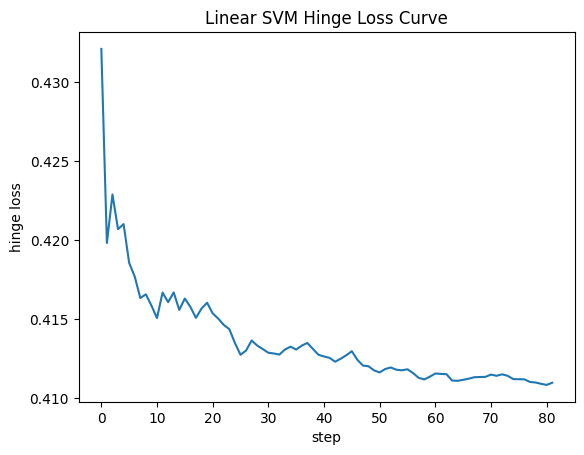

In [6]:
from sklearn.metrics import hinge_loss

hinge_curve = []

for i in range(1000, len(X_train_s), 2000):
    # calibrated model has no decision_function → use pseudo-margin from predict_proba
    probs = clf.predict_proba(X_train_s[:i])[:, 1]
    margins = probs * 2 - 1  # scale [0,1] → [-1,1]
    
    hl = hinge_loss(y_train[:i], margins)
    hinge_curve.append(hl)

plt.plot(hinge_curve)
plt.title("Linear SVM Hinge Loss Curve")
plt.xlabel("step")
plt.ylabel("hinge loss")
plt.savefig("svm_loss_curve.png", dpi=200)
plt.show()


In [7]:
# ---------------------------------------------------------------
# Predict on TEST and create submission
# ---------------------------------------------------------------
test_prob = clf.predict_proba(X_test_s)[:, 1]
test_pred = (test_prob > 0.5).astype(int)

# Submission MUST include ProfileID
sub = pd.DataFrame({
    "ProfileID": test["ProfileID"],   # <--- IMPORTANT
    "risk_flag": test_pred
})

sub.to_csv("svm_submission.csv", index=False)
print("Saved: svm_submission.csv")


Saved: svm_submission.csv
